# **Task 5: End-to-End Data Pipeline for Book Analytics**
Expected duration: 5 days

Task Overview
## **Objective**:

Build a complete data pipeline to analyze IMDB-style Book Data using Python, SQL, and a visualization dashboard.

## **Deliverables**:

- **Data Ingestion**\
Load mock book data from a CSV file or simulate data from an API using Python.
- **Data Cleaning**\
Handle missing values, duplicates, and outliers in book-related fields such as ratings, votes, and publication year.
- **SQL Schema Design and Population**
    * Design a normalized database schema for storing the book data using SQLite or PostgreSQL.
    * Populate the database using the cleaned dataset.
- **Interactive Dashboard (Streamlit or Dash)**\
Build a web-based dashboard that allows users to filter and visualize:
    * Average book ratings by genre
    * Top-rated books by year
    * Revenue vs. votes
    * Book count by genre over the years


# **1.Data Ingestion**

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read the csv dataset 
df = pd.read_csv('data/books.csv')
df.head()

,BookID,Title,Genre,PublicationYear,Rating,Votes,RevenueMillions
0,0,Book 0,Romance,2011,4.2,3862,32.22
1,1,Book 1,Non-Fiction,2020,3.5,13170,4.41
2,2,Book 2,Science Fiction,1973,4.3,16332,37.19
3,3,Book 3,Non-Fiction,1988,4.3,397,10.51
4,4,Book 4,Non-Fiction,2017,3.8,46901,19.48


In [102]:
print(df.shape)          # Rows & columns
print(df.info())         # Data types


(10000, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   BookID           10000 non-null  int64  
 1   Title            10000 non-null  object 
 2   Genre            10000 non-null  object 
 3   PublicationYear  10000 non-null  int64  
 4   Rating           10000 non-null  float64
 5   Votes            10000 non-null  int64  
 6   RevenueMillions  10000 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 547.0+ KB
None


In [103]:
df.describe()   # Summary statistics

,BookID,PublicationYear,Rating,Votes,RevenueMillions
count,10000.00000,10000.00000,10000.000000,10000.000000,10000.000000
mean,4999.50000,1986.48960,4.003170,24816.082800,25.163221
std,2886.89568,21.42787,0.694034,14394.196041,14.432541
min,0.00000,1950.00000,0.900000,12.000000,0.100000
25%,2499.75000,1968.00000,3.500000,12374.500000,12.760000
50%,4999.50000,1987.00000,4.000000,24755.500000,25.080000
75%,7499.25000,2005.00000,4.500000,37189.000000,37.810000
max,9999.00000,2023.00000,6.900000,49991.000000,49.990000


# **2.Data Cleaning**

In [35]:
df.isnull().any()

BookID             False
Title              False
Genre              False
PublicationYear    False
Rating             False
Votes              False
RevenueMillions    False
dtype: bool

In [36]:
df.duplicated().sum()

np.int64(0)

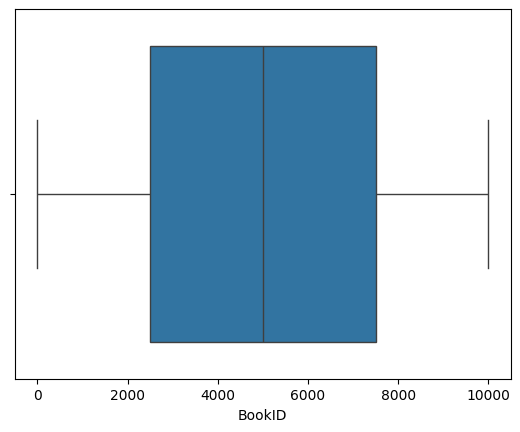

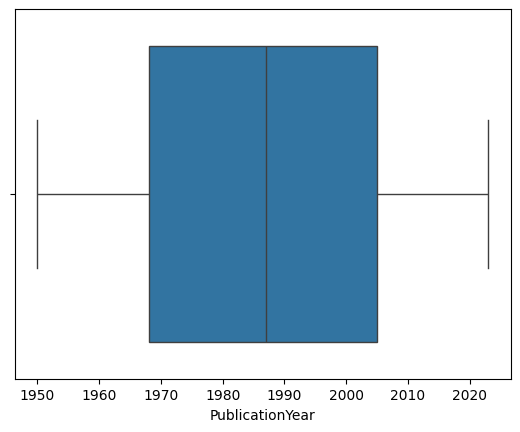

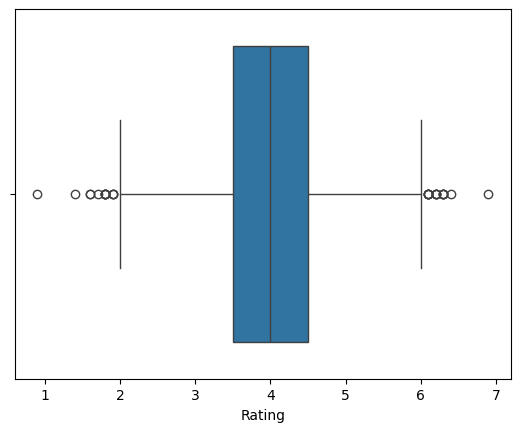

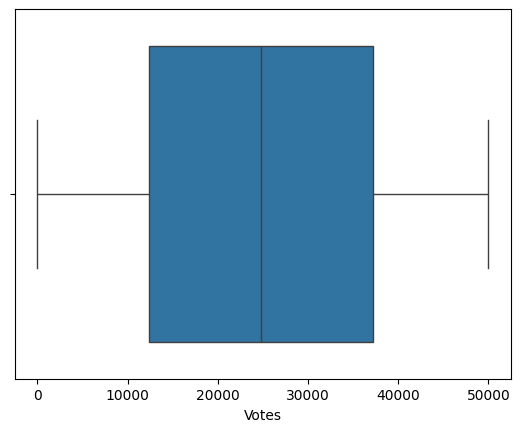

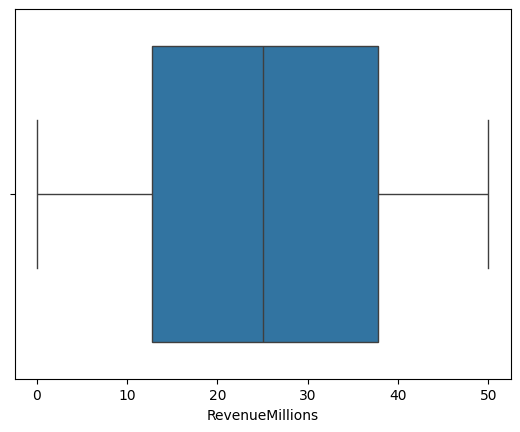

In [37]:
num_cols = df.select_dtypes(include=np.number)
 
import seaborn as sns
# plot boxplot for outlier detection 
for col in num_cols:
    sns.boxplot(x=df[col])
    plt.show()

In [38]:
df.dtypes

BookID               int64
Title               object
Genre               object
PublicationYear      int32
Rating             float64
Votes                int32
RevenueMillions    float64
dtype: object

In [39]:
df['RevenueMillions'].min()


np.float64(0.1)

# **3.SQL Schema Design and Population** 

In [41]:
# 1. Create & Connect Database
import sqlite3
connection = sqlite3.connect("D:/Data Science/Codes/Internship/Task 5/database.db")

cursor = connection.cursor()


In [94]:
tables = {
    "genres":'''
        create table if not exists genres (
        id integer primary key autoincrement,
        name varchar(100) unique
        )
    ''',
    "books":'''
        create table if not exists books (
        id integer primary key autoincrement,
        title varchar(100) not null,
        genre_id integer,
        publication_year integer,
        foreign key (genre_id) references genres(id)
        )
        ''',
    "book_stats":'''
        create table if not exists book_stats(
            id integer primary key autoincrement,
            book_id integer,
            rating real,
            votes integer,
            revenue_millions real,
            foreign key (book_id) references books(id)
        )
    '''
}


In [ ]:
for table_name,query in tables.items():
    cursor.execute(query)
    print(f"Table {table_name} is created(if not exists)")

connection.commit()
connection.close()

Table genres is created(if not exists)
Table books is created(if not exists)
Table book_stats is created(if not exists)


In [58]:
df.head()

,BookID,Title,Genre,PublicationYear,Rating,Votes,RevenueMillions
0,0,Book 0,Romance,2011,4.2,3862,32.22
1,1,Book 1,Non-Fiction,2020,3.5,13170,4.41
2,2,Book 2,Science Fiction,1973,4.3,16332,37.19
3,3,Book 3,Non-Fiction,1988,4.3,397,10.51
4,4,Book 4,Non-Fiction,2017,3.8,46901,19.48


In [92]:
connection = sqlite3.connect('database.db')
cursor = connection.cursor()

In [96]:
# Insert genres in the genres table
unique_genres = df['Genre'].unique()
for genre in unique_genres:
    cursor.execute('insert or ignore into genres (name) values (?)',(genre,))
    connection.commit()

In [97]:
# Fetch all genres id and store in dictionary
cursor.execute('select * from genres')
genre_map = {}
for row in cursor.fetchall():
    genre_map[row[1]] = row[0]
genre_map

{'Romance': 1,
 'Non-Fiction': 2,
 'Science Fiction': 3,
 'Mystery': 4,
 'Fiction': 5}

In [98]:
# Insert books and books stats 
for _,row in df.iterrows():
    cursor.execute('''
        insert into books (title,genre_id,publication_year) values
        (?,?,?)
    ''',
    (row['Title'],genre_map[row['Genre']],int(row['PublicationYear']))
    )

    book_id = cursor.lastrowid

    # Insert stats
    cursor.execute('''
        insert into book_stats (book_id,rating,votes,revenue_millions) values
        (?,?,?,?)
    ''',
    (book_id,row['Rating'],row['Votes'],row['RevenueMillions'])
    )
# Commit and close
connection.commit()
connection.close()
print("✅ Data successfully inserted into SQLite database!")

✅ Data successfully inserted into SQLite database!


# **4.Data Visualization** 

### 1. Average Book Ratings by Genre

In [108]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("database.db")

# Example: Average rating by genre
query = """
SELECT g.name AS genre,
       ROUND(AVG(bs.rating), 2) AS avg_rating
FROM genres g
JOIN books b ON g.id = b.genre_id
JOIN book_stats bs ON b.id = bs.book_id
GROUP BY g.name
ORDER BY avg_rating DESC;
"""
df_avg_rating = pd.read_sql(query, conn)
df_avg_rating


,genre,avg_rating
0,Fiction,4.03
1,Non-Fiction,4.01
2,Science Fiction,4.00
3,Romance,4.00
4,Mystery,3.98


### 2. Top-Rated Books by Year

In [109]:
query ='''
SELECT b.publication_year,
       b.title,
       MAX(bs.rating) AS top_rating
FROM books b
JOIN book_stats bs ON b.id = bs.book_id
GROUP BY b.publication_year
ORDER BY b.publication_year, top_rating DESC;

'''
df_top_books = pd.read_sql(query, conn)
df_top_books


,publication_year,title,top_rating
0,1950,Book 5836,6.9
1,1951,Book 8898,5.7
2,1952,Book 6663,5.9
3,1953,Book 9560,5.9
4,1954,Book 5053,5.7
...,...,...,...
69,2019,Book 1193,5.6
70,2020,Book 6448,6.1
71,2021,Book 5570,6.0
72,2022,Book 4774,5.7


### 3. Revenue vs. Votes (Scatter Data)

In [110]:
query = '''
SELECT b.title,
       bs.votes,
       bs.revenue_millions
FROM books b
JOIN book_stats bs ON b.id = bs.book_id;

'''
df_book_stats = pd.read_sql(query, conn)
df_book_stats


,title,votes,revenue_millions
0,Book 0,3862,32.22
1,Book 1,13170,4.41
2,Book 2,16332,37.19
3,Book 3,397,10.51
4,Book 4,46901,19.48
...,...,...,...
9995,Book 9995,44900,46.90
9996,Book 9996,48558,28.66
9997,Book 9997,10436,32.12
9998,Book 9998,12546,28.99


### 4. Book Count by Genre Over the Years

In [111]:
query = '''
SELECT b.publication_year,
       g.name AS genre,
       COUNT(*) AS book_count
FROM books b
JOIN genres g ON g.id = b.genre_id
GROUP BY b.publication_year, g.name
ORDER BY b.publication_year, g.name;

'''
df_genre_counts = pd.read_sql(query, conn)
df_genre_counts


,publication_year,genre,book_count
0,1950,Fiction,22
1,1950,Mystery,32
2,1950,Non-Fiction,22
3,1950,Romance,21
4,1950,Science Fiction,29
...,...,...,...
365,2023,Fiction,29
366,2023,Mystery,31
367,2023,Non-Fiction,29
368,2023,Romance,33
